In [1]:
library(SPOTlight)
library(Seurat)
library(dplyr)
library(reshape2)
library(RColorBrewer)
library(ggplot2)
library(scater)
library(scran)
library(SpatialExperiment)
library(anndata)

Attaching SeuratObject


载入程辑包：‘dplyr’


The following object is masked from ‘package:Biobase’:

    combine


The following objects are masked from ‘package:BiocGenerics’:

    combine, intersect, setdiff, union


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


载入需要的程辑包：SingleCellExperiment

载入需要的程辑包：SummarizedExperiment

载入需要的程辑包：MatrixGenerics

载入需要的程辑包：matrixStats


载入程辑包：‘matrixStats’


The following object is masked from ‘package:dplyr’:

    count


The following objects are masked from ‘package:Biobase’:

    anyMissing, rowMedians



载入程辑包：‘MatrixGenerics’


The following objects are masked from ‘package:matrixStats’:

    colAlls, colAnyNAs, colAnys, colAvgsPerRowSet, colCollapse,
    colCounts, colCummaxs, colCummins, colCumprods, colCumsums,
    colDiffs, colIQRDiffs, colIQRs, colLogSumExps, colMadDiffs,
    colMads, colMaxs, colMeans2, colMedians, colM

In [2]:
print("Convert from Scanpy to Seurat...")
data <- read_h5ad("HCC02_B_bin50_tissue_only_spatialObj.h5ad")
data <- CreateSeuratObject(counts = t(as.matrix(data$X)), meta.data = data$obs)
saveRDS(data, "HCC02_B_bin50_tissue_only_spatialObj.rds")

[1] "Convert from Scanpy to Seurat..."


Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 40.5 GiB”


In [3]:
rm(data)
gc()

,used,(Mb),gc trigger,(Mb),max used,(Mb)
Ncells,9001538,480.8,16744924,894.3,16744924,894.3
Vcells,15677404,119.7,10444079648,79682.1,11131137317,84923.9


In [4]:
print ("Set parameters...")
outdir <- './'
single_cell_rds <- 'singlecell_ref.rds' 
topN=100
hvg=3000

spatial_rds <- 'HCC02_B_bin50_tissue_only_spatialObj.rds'

min_prop=0.09
weight="minuP"
pt.size=0.4 

proname <- 'HCC02_B_bin50_tissue_only'

[1] "Set parameters..."


In [5]:
print ("Read scRNA...")
sc <- readRDS(single_cell_rds) #single cell annotation file
Idents(sc) <- sc@meta.data$celltype
DefaultAssay(sc) <- "RNA"
sc <- subset(sc, subset = nFeature_RNA > 50 & nCount_RNA > 100)

print("Now let's go to find Markers...")
cluster_markers_all <- FindAllMarkers(object = sc, 
                                      assay = "RNA", 
                                      slot = "counts", 
                                      verbose = TRUE, 
                                      only.pos = TRUE)

cluster_markers_all <- mutate(cluster_markers_all, "minuP"=1-(cluster_markers_all$p_val))
cluster_markers_all <- mutate(cluster_markers_all, "FC"=2^cluster_markers_all$avg_log2FC)

markers <- cluster_markers_all %>% group_by(cluster) %>% top_n(n = 20, wt = avg_log2FC)
write.csv(markers, file=file.path(paste0(outdir,'/',proname,'_SC_allMarkers_top20.csv')))
write.csv(cluster_markers_all, file=file.path(paste0(outdir,'/',proname,'_SC_allMarkers.csv')))

[1] "Read scRNA..."
[1] "Now let's go to find Markers..."


Calculating cluster T

Calculating cluster Plasma

Calculating cluster B

Calculating cluster Myeloid

Calculating cluster pDC

Calculating cluster Fibroblast

Calculating cluster Hepatocyte

Calculating cluster Endothelial



In [6]:
print("Now let's go to find HVG...")
se_obj <- FindVariableFeatures(sc, nfeatures = hvg)
hvg_genes <- c(VariableFeatures(se_obj))
write.csv(hvg_genes, file=file.path(paste0(outdir,'/',proname,'_SC_HVG',hvg,'.csv')))
rm(se_obj)
gc()

[1] "Now let's go to find HVG..."


,used,(Mb),gc trigger,(Mb),max used,(Mb)
Ncells,9153836,488.9,16744924,894.3,16744924,894.3
Vcells,78055294,595.6,8355263719,63745.7,11131137317,84923.9


[1] "Now let's go to select 100 random cells for each cluster..."
[1] "Total cells used: "
[1] 694


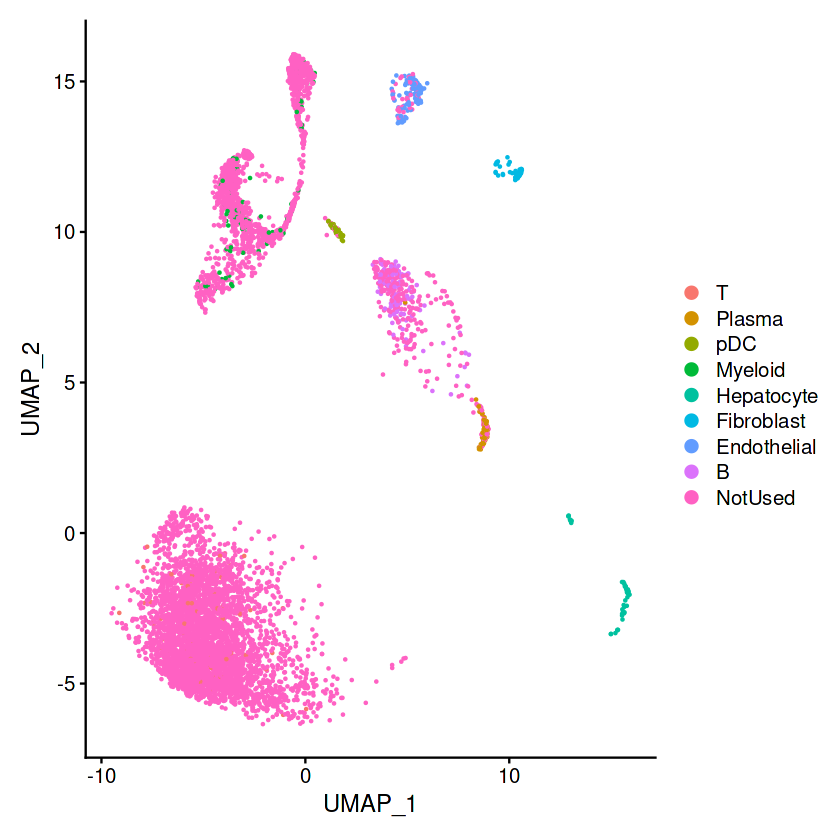

In [7]:
print("Now let's go to select 100 random cells for each cluster...")
Idents(sc) <- "NotUsed"
cells <- lapply(split(sc@meta.data, sc@meta.data[, "celltype"]), function(subdf) {
    # Determine n_sample, if the size of the group is < topN use all the group, if not just use topN
    n_sample <- if_else(nrow(subdf) < topN, as.numeric(nrow(subdf)), as.numeric(topN))
    # Subset a random selection of that group and get the identifiers
    tmp_ds <- subdf[sample(seq_len(nrow(subdf)), n_sample), ] %>%
      tibble::rownames_to_column("barcodeID") %>%
      dplyr::pull(barcodeID)
    df <- data.frame(tmp_ds,rep(as.character(unique(subdf[["celltype"]])),length(tmp_ds)))
    return(df)
})
for (i in 1:length(cells)){
    sc <- SetIdent(sc,cells=cells[[i]][,1],as.character(unique(unique(cells[[i]][,2]))))
    if (i==1){cellmerged <- as.vector(cells[[i]][,1])}
    else{cellmerged <- as.character(c(as.vector(cellmerged),as.vector(cells[[i]][,1])))}
}

hcc_sc <- sc[, cellmerged]
print ("Total cells used: ")
print (length(colnames(hcc_sc)))

DimPlot(sc, reduction = "umap")

Idents(hcc_sc) <- hcc_sc@meta.data$celltype
saveRDS(object = hcc_sc, file = file.path(paste0(outdir,'/',proname,"_random",topN,'_sc.rds')))

In [8]:
print ("Read sptial...")
hcc_st <- readRDS(spatial_rds) 
hcc_st <- subset(hcc_st, subset = nFeature_Spatial > 50 & nCount_Spatial > 100)
hcc_st@images$slice1@spot.radius <- 0.01

#prepare reference
print ("Read samples single-cell...")
hcc_sc<-readRDS(file.path(paste0(outdir,'/',proname,"_random",topN,'_sc.rds')))
Idents(hcc_sc) <- hcc_sc@meta.data$celltype
DefaultAssay(hcc_sc) <- "RNA"

cluster_markers_all <- as.data.frame(markers)

[1] "Read sptial..."
[1] "Read samples single-cell..."


[1] "Spatial non-zero genes: 30764"


,used,(Mb),gc trigger,(Mb),max used,(Mb)
Ncells,9351011,499.4,16744924,894.3,16744924,894.3
Vcells,233653882,1782.7,6684210976,50996.5,11131137317,84923.9


[1] "Now let's go to train NMF..."


Warning message in .set_groups_if_null(x):
“Grouping cells into celltypes by Idents(x)”
Scaling count matrix

Seeding initial matrices

Training NMF model

Time for training: 0.5min



,used,(Mb),gc trigger,(Mb),max used,(Mb)
Ncells,9501458,507.5,16744924,894.3,16744924,894.3
Vcells,234413580,1788.5,4277895025,32637.8,11131137317,84923.9


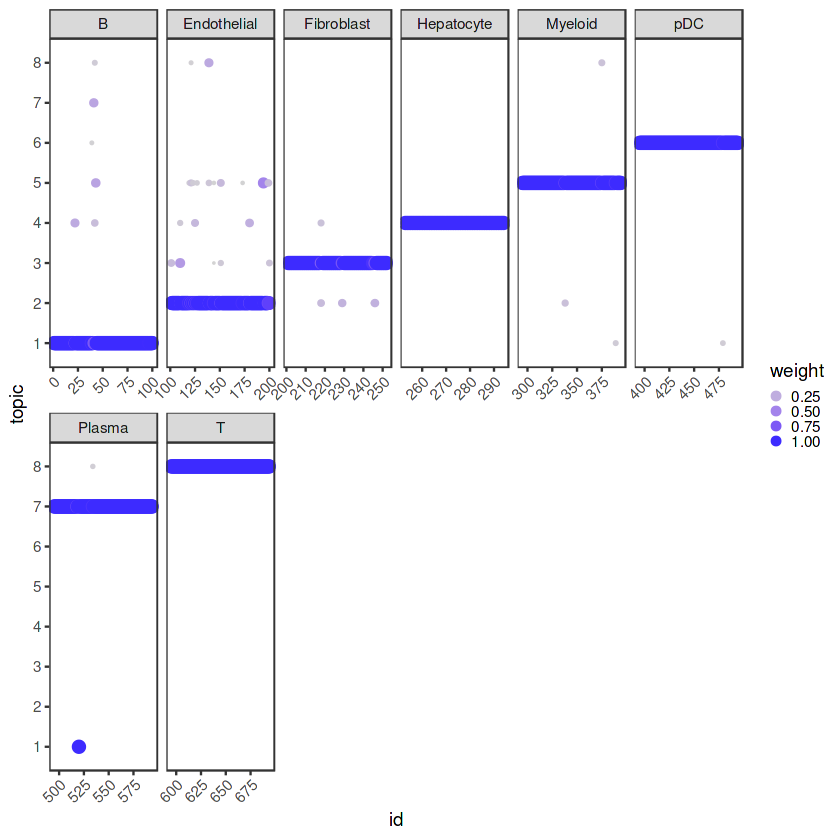

In [9]:
# train NMF model using all genes but not read all spatial data
total_counts_per_genes <- rowSums(hcc_st@assays$Spatial@counts)
total_counts_per_genes <- total_counts_per_genes[!total_counts_per_genes %in% 0]
print(paste0("Spatial non-zero genes: ",length(names(total_counts_per_genes))))
st <- subset(x=hcc_st, features=as.character(names(total_counts_per_genes)))
st <- subset(st,downsample=2)
st <- as.matrix(st@assays$Spatial@counts)
st <- st+1
rm(total_counts_per_genes)
gc()

set.seed(123)
print("Now let's go to train NMF...")
mod_ls <- trainNMF(x = hcc_sc, y = st,
                              mgs = cluster_markers_all,
                              hvg = hvg_genes,
                              weight_id = weight,
                              group_id = "cluster",
                              gene_id = "gene",
                              n_top = NULL,
                              scale = TRUE,
                              model = "ns",
                              verbose = TRUE)

plotTopicProfiles(
    x = mod_ls[["mod"]],
    y = hcc_sc@meta.data$celltype,
    facet = TRUE,
    min_prop = 0.01,
    ncol = 6)
rm(st)
gc()

In [10]:
# celltype prediction
celltype_predict <- function(hcc_st_mtx,mod_ls){
    set.seed(123)
    res <- runDeconvolution(hcc_st_mtx, 
                            mod_ls[["mod"]], 
                            mod_ls[["topic"]],
                            scale = FALSE, 
                            min_prop = min_prop, 
                            verbose = TRUE)
    
    decon_mtrx <- res[["mat"]]
    res_ss <- res[["res_ss"]]
    
    predict_CellType = apply(decon_mtrx[,which(colnames(decon_mtrx) != "res_ss")], 1, 
                             function(x){
                                 index = which.max(x)
                                 if(length(index)==0){
                                     a = 'None'
                                 }else{
                                     a = colnames(decon_mtrx)[index]
                                 }
                                 return(a)}
                            )
    first_ratio = apply(decon_mtrx[,which(colnames(decon_mtrx) != "res_ss")], 1,
                         function(x){
                                 first <- tail(sort(x),1)
                                 return(first)}
                        )
    second_ratio = apply(decon_mtrx[,which(colnames(decon_mtrx) != "res_ss")], 1,
                         function(x){
                                second <- tail(sort(x),2)[1]
                                 return(second)}
                        )

    predict_matrix <- cbind(decon_mtrx,predict_CellType,first_ratio,second_ratio,res[["res_ss"]])
    return (predict_matrix)
}

scale_uv <- function(x) {
    sds <- matrixStats::rowSds(x, na.rm = TRUE)
    count_mtrx<-t(scale(t(x), center = FALSE, scale = sds))
    # Set all 0s if the row is NA
    pos_0 <- which(rowSums(is.na(count_mtrx)) == ncol(count_mtrx))
    count_mtrx[pos_0, ] <- 0
    return(count_mtrx)
}

if (length(rownames(hcc_st@meta.data))>50000){ 
    gc()
    predict_mtx <-c()
    splitN <- round(length(rownames(hcc_st@meta.data))/50000)
    interval <- floor(length(rownames(hcc_st@meta.data))/splitN)
    start <- 1
    end <- interval
    for (i in 1:splitN){
        print (paste0('celltype_predict_',i,'/',splitN,'...'))
        gc()
        if(i==splitN){
            hcc_st_subset <- subset(hcc_st,cells=rownames(hcc_st@meta.data)[start:length(rownames(hcc_st@meta.data))])
            hcc_st_mtx = as.matrix(hcc_st_subset@assays$Spatial@counts)
            hcc_st_mtx = scale_uv(hcc_st_mtx)
            mtx <- celltype_predict(hcc_st_mtx,mod_ls)
            predict_mtx <- rbind(predict_mtx,mtx)
        }
        else{
            hcc_st_subset <- subset(hcc_st,cells=rownames(hcc_st@meta.data)[start:end])
            hcc_st_mtx = as.matrix(hcc_st_subset@assays$Spatial@counts)
            hcc_st_mtx = scale_uv(hcc_st_mtx)
            mtx <-celltype_predict(hcc_st_mtx,mod_ls)
            predict_mtx <- rbind(predict_mtx,mtx)
            start = start + interval
            end = end + interval
        }
    }
}else{
        print (paste0('celltype_predict_all...'))
        hcc_st_mtx = as.matrix(hcc_st@assays$Spatial@counts)
        hcc_st_mtx = scale_uv(hcc_st_mtx)
        predict_mtx<-celltype_predict(hcc_st_mtx,mod_ls)
}

hcc_st@meta.data <- cbind(hcc_st@meta.data, predict_mtx,stringsAsFactors = FALSE)
saveRDS(hcc_st,file=file.path(paste0(outdir,"/",proname,'_spotlight_Spatial.rds')))
rm(predict_mtx)
gc()

[1] "celltype_predict_1/1..."


Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 12.3 GiB”
Deconvoluting mixture data



,used,(Mb),gc trigger,(Mb),max used,(Mb)
Ncells,9638476,514.8,16744924,894.3,16744924,894.3
Vcells,1883721723,14371.7,6552370731,49990.7,11131137317,84923.9


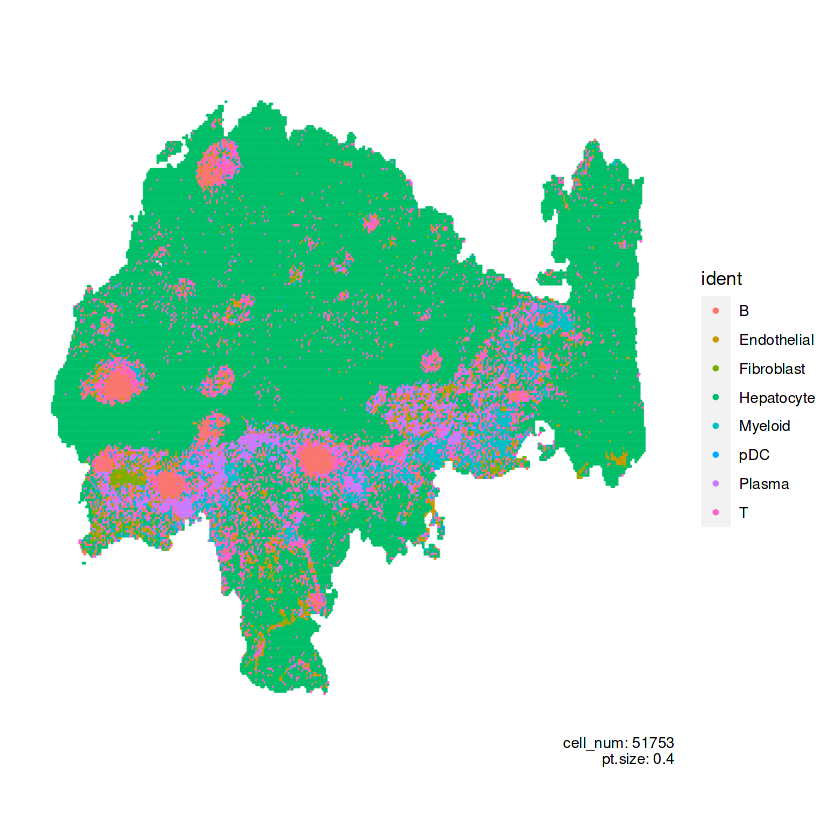

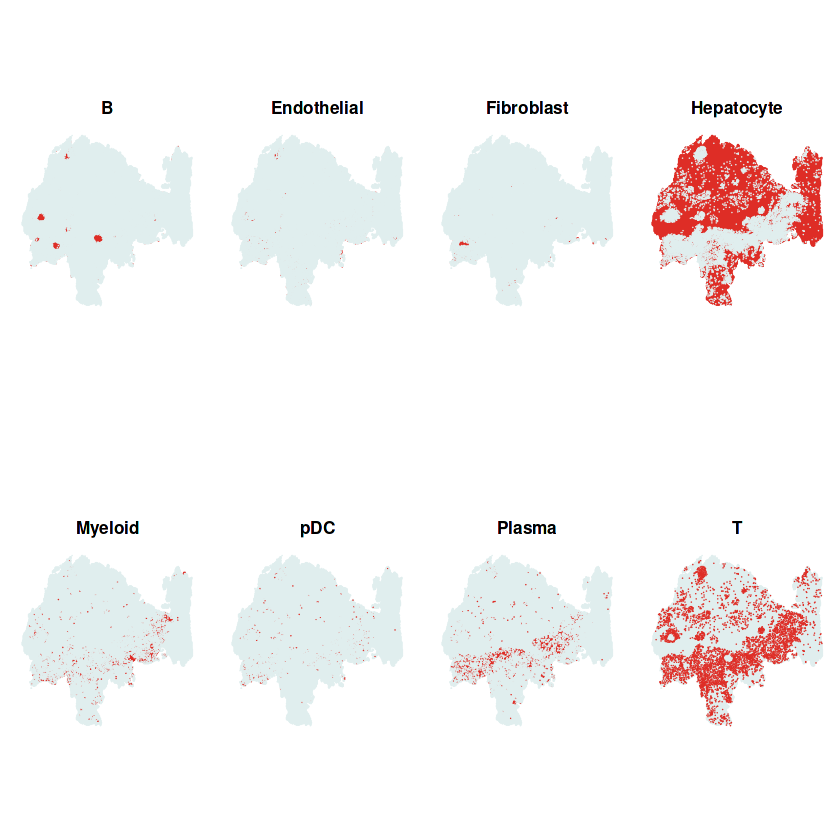

In [11]:
# plot spotlight clusters
hcc_st$predict_CellType <- factor(hcc_st$predict_CellType)
Idents(hcc_st) <- hcc_st$predict_CellType

require(RColorBrewer)
col <- c(brewer.pal(9, "Set1")[c(1:5, 7, 6, 8, 9)], brewer.pal(9, "Pastel1")[c(7, 2, 3, 5, 1)], brewer.pal(12, "Set3")[c(-2, -4, -6, -9, -11)], brewer.pal(8, "Set2")[c(3, 4, 7)], brewer.pal(8, "Pastel2")[8], brewer.pal(12, "Paired")[c(5, 6, 9, 10, 12)])


print(SpatialPlot(hcc_st, stroke=NA, image.alpha = 0, pt.size.factor=pt.size)+labs(caption = paste0("cell_num: ", ncol(hcc_st),"\n","pt.size: ",pt.size)))


plist <-  SpatialPlot(hcc_st, cells.highlight = CellsByIdentities(object = hcc_st),
                  cols.highlight = c("#DE2D26", "#E0EEEE"), facet.highlight = TRUE,
                  stroke = NA, combine = F, image.alpha = 0,label.size=8, pt.size.factor=pt.size)
for (i in seq_len(length(plist))) {
  plist[[i]] <- plist[[i]] + theme(plot.title = element_text(size=10,face="bold"))
}

print(cowplot::plot_grid(plotlist = plist, align = "hv", nrow = 2))